In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### A. Data Exploration

In [2]:
# Open file and inspect first five rows.
df_A1 = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2013/results.csv')
df_A1.head()

,25k,age,name,division,10k,gender,half,official,bib,ctz,...,overall,pace,state,30k,5k,genderdiv,20k,35k,city,40k
0,49.87,28,"Cassidy, Josh R.",9,18.18,M,40.93,90.90,W1,NaN,...,9,3.47,ON,62.07,8.90,9,38.80,74.73,Toronto,85.55
1,77.27,30,"Korir, Wesley",5,30.90,M,64.90,132.50,1,NaN,...,5,5.07,NaN,92.97,15.90,5,61.52,108.78,Kenya,124.77
2,77.23,23,"Desisa, Lelisa",1,30.90,M,64.92,130.37,2,NaN,...,1,4.98,NaN,92.72,15.93,1,61.53,108.68,Ambo,123.78
3,50.50,32,"Fearnley, Kurt H.",5,18.73,M,42.00,88.43,W2,NaN,...,5,3.38,NaN,61.35,8.98,5,39.88,73.00,Hamilton,83.43
4,48.75,39,"Hokinoue, Kota",3,18.18,M,40.57,87.22,W3,NaN,...,3,3.33,NaN,59.92,8.92,3,38.55,71.68,Iizuka,81.88


In [3]:
# Check shape.
df_A1.shape

(16164, 21)

In [4]:
# Check datatypes.
df_A1.dtypes

25k           object
age            int64
name          object
division       int64
10k           object
gender        object
half          object
official     float64
bib           object
ctz           object
country       object
overall        int64
pace         float64
state         object
30k           object
5k            object
genderdiv      int64
20k           object
35k           object
city          object
40k           object
dtype: object

In [5]:
# Check for nulls.
df_A1.isnull().sum()

25k              0
age              0
name             0
division         0
10k              0
gender           0
half             0
official         0
bib              0
ctz          15407
country          0
overall          0
pace             0
state         1463
30k              0
5k               0
genderdiv        0
20k              0
35k              0
city             1
40k              0
dtype: int64

In [6]:
# Drop unnecessary features.
df_A1 = df_A1.drop(['name', 'division', 'gender', 'bib', 'ctz', 'country', 'state', 'genderdiv', 'city'], axis=1)

# Create function to replace '-' with 0 and convert columns to numeric.
df_obj = df_A1.columns[df_A1.dtypes.eq('object')]
convert_col = lambda col_obj: pd.to_numeric(col_obj.replace('-','0'))
df_A1[df_obj] = df_A1[df_obj].applymap(convert_col)

In [7]:
# Official feature description.
df_A1.official.describe()

count    16164.000000
mean       208.159470
std         23.743608
min         85.530000
25%        191.727500
50%        209.225000
75%        225.230000
max        284.230000
Name: official, dtype: float64

In [8]:
# Create function that assigns categories on the official feature.
def speed_cat(row):
    if row['official'] >= df_A1.official.quantile(0.75):
        val = 0
    elif (row['official'] >= df_A1.official.quantile(0.50)) & (row['official'] < df_A1.official.quantile(0.75)):
        val = 1
    elif (row['official'] >= df_A1.official.quantile(0.25)) & (row['official'] < df_A1.official.quantile(0.50)):
        val = 2
    else:
        val = 3
    return val

# Create a class feature based on the official feature.
df_A1['class'] = df_A1.apply(speed_cat, axis=1)

In [9]:
# Define the features and the outcome.
X = df_A1.drop(['official', 'class'], axis=1)
y = df_A1['class']

# Normalize the features
from sklearn.preprocessing import normalize
X_norm = normalize(X)

# Reduce to four components.
from sklearn.decomposition import PCA
X_pca = PCA(4).fit_transform(X_norm)

### B. K-Means

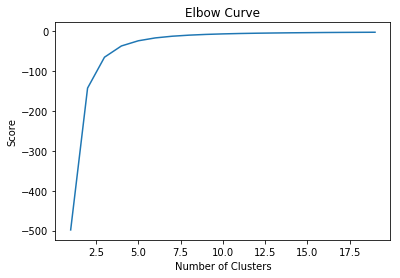

In [10]:
# Create an elbow curve to determine the optimum number of clusters.
from sklearn.cluster import KMeans
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X_norm).score(X_norm) for i in range(len(kmeans))]

import pylab as pl
pl.plot(Nc,score)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

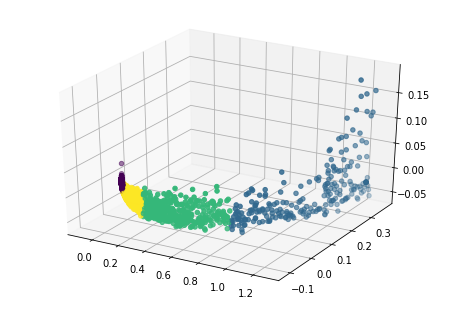

             precision    recall  f1-score   support

          0       0.29      1.00      0.45      4042
          1       0.00      0.00      0.00      4040
          2       0.00      0.00      0.00      4041
          3       1.00      0.38      0.55      4041

avg / total       0.32      0.34      0.25     16164



In [11]:
# Calculate predicted values.
pred_kmeans = KMeans(n_clusters=4, random_state=42).fit_predict(X_pca)

# Plot in 3D.
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1],  X_pca[:, 2], c=pred_kmeans)
plt.show()

# Run classification report.
from sklearn.metrics import classification_report
print(classification_report(y, pred_kmeans))

### C. Mean Shift

In [12]:
# Set bandwidth.
from sklearn.cluster import MeanShift, estimate_bandwidth
bandwidth = estimate_bandwidth(X_pca, quantile=0.5)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
pred_ms = ms.fit_predict(X_pca)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 10


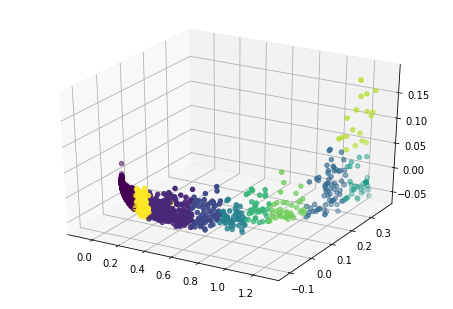

             precision    recall  f1-score   support

          0       0.26      1.00      0.42      4042
          1       0.00      0.00      0.00      4040
          2       0.00      0.00      0.00      4041
          3       0.99      0.02      0.03      4041
          4       0.00      0.00      0.00         0
          5       0.00      0.00      0.00         0
          6       0.00      0.00      0.00         0
          7       0.00      0.00      0.00         0
          8       0.00      0.00      0.00         0
          9       0.00      0.00      0.00         0

avg / total       0.31      0.25      0.11     16164



C:\Users\James\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [13]:
# Plot in 3D.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=labels)
plt.show()

# Run classification report.
print(classification_report(y, pred_ms))

### D. Spectral

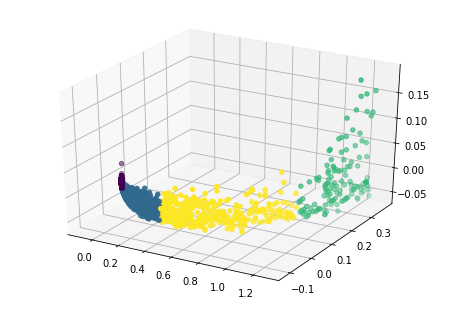

             precision    recall  f1-score   support

          0       0.30      1.00      0.46      4042
          1       0.00      0.00      0.00      4040
          2       0.01      0.00      0.00      4041
          3       1.00      0.08      0.15      4041

avg / total       0.33      0.27      0.15     16164



In [14]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=4)

#Predicted clusters.
pred_sc = sc.fit_predict(X_pca)

#Graph results.
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=pred_sc)
plt.show()

# Run classification report.
print(classification_report(y, pred_sc))

### E. Affinity Propagation

In [15]:
'''
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Fit the model.
af = AffinityPropagation().fit(X_pca)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))
'''

"\nfrom sklearn.cluster import AffinityPropagation\nfrom sklearn import metrics\n\n# Fit the model.\naf = AffinityPropagation().fit(X_pca)\n\n# Pull the number of clusters and cluster assignments for each data point.\ncluster_centers_indices = af.cluster_centers_indices_\nn_clusters_ = len(cluster_centers_indices)\nlabels = af.labels_\n\nprint('Estimated number of clusters: {}'.format(n_clusters_))\n"

In [16]:
'''
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_pca[cluster_centers_indices[k]]
    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_pca[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()
'''

"\nfrom itertools import cycle\n\nplt.figure(1)\nplt.clf()\n\n# Cycle through each cluster and graph them with a center point for the\n# exemplar and lines from the exemplar to each data point in the cluster.\ncolors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')\nfor k, col in zip(range(n_clusters_), colors):\n    class_members = labels == k\n    cluster_center = X_pca[cluster_centers_indices[k]]\n    plt.plot(X_pca[class_members, 0], X_pca[class_members, 1], col + '.')\n    plt.plot(cluster_center[0],\n             cluster_center[1],\n             'o',\n             markerfacecolor=col,\n             markeredgecolor='k')\n    for x in X_pca[class_members]:\n        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)\n\nplt.title('Estimated number of clusters: {}'.format(n_clusters_))\nplt.show()\n"

KMeans provides the highest accuracy with the least number of clusters. Unable to complete affinity propagation as it takes an inordinate amount of time to run.